# Set Environment

In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.1 MB/s eta 0:00:00


In [2]:
# Import libraries
from datetime import timedelta
import os
import category_encoders as ce
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas_gbq
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
# plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [3]:
# authenticate
auth.authenticate_user()

In [4]:
# Set up environment variables
project_id = 'majestic-bounty-432904-c4'
# if project_id == 'CHANGE-ME':
#   raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pandas_gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
# if you want to use the demo, change this to mimic_demo
dataset = 'mimiciv'

# Feature Selection

## Select stroke patients

In [5]:
select_stroke_query = f"""
SELECT *
FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
WHERE icd_code LIKE 'I61%' OR icd_code LIKE 'I63%';
"""
stroke_df = run_query(select_stroke_query)
stroke_subject_ids = stroke_df['subject_id'].unique().tolist()
stroke_hadm_ids = stroke_df['hadm_id'].unique().tolist()

Downloading: 100%|██████████|


## Demographics

### admittime, dischtime, deathtime, insurance, martial status, race

In [6]:
select_demographics_query_in_admission = f"""
SELECT subject_id, hadm_id, admittime, dischtime, deathtime, insurance, marital_status, race
FROM `physionet-data.mimiciv_hosp.admissions`
WHERE subject_id IN ({', '.join(map(str, stroke_subject_ids))})
AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))});
"""
demographics_df = run_query(select_demographics_query_in_admission)
demographics_df

Downloading: 100%|██████████|


,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND
...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE


### gender, age

In [7]:

select_gender_and_age_query = f"""
SELECT subject_id,gender, anchor_age
FROM `physionet-data.mimiciv_hosp.patients`
WHERE subject_id IN ({', '.join(map(str, stroke_subject_ids))});
"""
gender_and_df = run_query(select_gender_and_age_query)
demographics_df = demographics_df.merge(gender_and_df, on=['subject_id'], how='inner')
demographics_df

Downloading: 100%|██████████|


,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52
...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62


### weight

In [8]:
# 226512 Admission weight
select_weight_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as weight
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 226512 AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
weight_df = run_query(select_weight_query)
weight_df

Downloading: 100%|██████████|


,subject_id,hadm_id,weight
0,16918051,22359670,66.4
1,12285198,21543313,47.9
2,17910874,24323121,77.0
3,10488542,24635169,112.0
4,10422510,25554996,86.3
...,...,...,...
2412,16051265,26266829,79.0
2413,15459123,24220403,100.0
2414,18080257,29272617,109.6
2415,10445331,24253259,101.4


In [9]:
demographics_df = demographics_df.merge(weight_df, on=['subject_id','hadm_id'], how='left')
demographics_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0


## Vital signs

In [10]:
# 220045  heart rate
# 220210  Respiratory Rate
# 220050  Arterial Blood Pressure systolic
# 220051  Arterial Blood Pressure diastolic
# 220052  Arterial Blood Pressure mean
# 228232  PAR-Oxygen saturation

select_vital_signs_query = f"""
SELECT *
FROM `physionet-data.mimiciv_icu.d_items`
WHERE itemid IN (220045, 220210, 220050, 220051, 220052, 228232);
"""
vital_signs_query = run_query(select_vital_signs_query)
vital_signs_query


Downloading: 100%|██████████|


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220210,Respiratory Rate,RR,chartevents,Respiratory,insp/min,Numeric,NaN,NaN
1,228232,PAR-Oxygen saturation,PAR-Oxygen saturation,chartevents,Routine Vital Signs,None,Text,NaN,NaN
2,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
3,220050,Arterial Blood Pressure systolic,ABPs,chartevents,Routine Vital Signs,mmHg,Numeric,90.0,140.0
4,220051,Arterial Blood Pressure diastolic,ABPd,chartevents,Routine Vital Signs,mmHg,Numeric,60.0,90.0
5,220052,Arterial Blood Pressure mean,ABPm,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN


### Heart Rate

In [11]:
select_hr_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as hr_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 220045 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
hr_df = run_query(select_hr_query)
hr_df

Downloading: 100%|██████████|


,subject_id,hadm_id,hr_value
0,10300586,24090224,82.163763
1,19599196,25893125,86.803097
2,16340856,26102439,91.025641
3,16582674,26691544,86.084799
4,17375900,23843896,102.783582
...,...,...,...
2415,13013944,25260856,79.058824
2416,13343032,23976080,96.800000
2417,14385971,23349521,94.000000
2418,17197845,24670538,72.571429


In [12]:
demographics_vitial_signs_df = demographics_df.merge(hr_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347


### Respiratory Rate

In [13]:
select_rr_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as rr_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 220210 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
rr_df = run_query(select_rr_query)
rr_df

Downloading: 100%|██████████|


,subject_id,hadm_id,rr_value
0,17132849,25522621,20.221996
1,16080701,22251317,16.564327
2,16076363,24509535,24.352000
3,15667830,27636169,16.226562
4,14263190,29006576,21.746269
...,...,...,...
2414,17783518,24738217,25.416667
2415,10591033,29656475,16.727273
2416,12417848,27066366,17.647059
2417,17197845,24670538,12.857143


In [14]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(rr_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959


### SPO2

In [15]:
select_SPO2_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as SPO2_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 228232 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
SPO2_df = run_query(select_SPO2_query)
SPO2_df

Downloading: 100%|██████████|


,subject_id,hadm_id,SPO2_value
0,14470386,20124738,1.0
1,16293620,24841345,2.0
2,11121125,21867186,0.0
3,19404265,26466590,1.0
4,15670628,22222874,1.0
...,...,...,...
177,18039197,26027112,1.0
178,10336855,24910923,1.0
179,14400261,26364498,0.0
180,17734862,27683014,0.0


In [16]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(SPO2_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN


### Arterial Blood Pressure systolic

In [17]:
select_BPS_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as BPS_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 220050 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
BPS_df = run_query(select_BPS_query)
BPS_df

Downloading: 100%|██████████|


,subject_id,hadm_id,BPS_value
0,19136033,27656130,122.786408
1,10357863,25031044,113.372611
2,17132849,25522621,119.537815
3,19310368,28920315,125.653846
4,16962213,27083222,129.484536
...,...,...,...
751,15962075,28966752,125.444444
752,16047924,29848513,133.802469
753,19408525,27839048,137.045455
754,12152088,20002810,133.555556


In [18]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(BPS_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN


### Arterial Blood Pressure diastolic

In [19]:
select_BPD_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as BPD_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 220051 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
BPD_df = run_query(select_BPD_query)
BPD_df



Downloading: 100%|██████████|


,subject_id,hadm_id,BPD_value
0,10057482,25416257,52.287117
1,16359089,23982922,77.584746
2,18257010,24586212,68.213542
3,10932567,20601385,55.035714
4,16326056,20121937,57.153846
...,...,...,...
751,17851944,24510690,47.593750
752,14263190,29006576,56.229167
753,19898116,22663876,73.320000
754,10557131,22308370,59.527778


In [20]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(BPD_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6,59.6
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN,NaN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN,NaN
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN,NaN


### Arterial Blood Pressure Mean

In [21]:
select_BPM_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as BPM_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 220052 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
BPM_df = run_query(select_BPM_query)
BPM_df

Downloading: 100%|██████████|


,subject_id,hadm_id,BPM_value
0,10215159,24039782,81.611111
1,19374373,21857828,85.404040
2,15857793,21064907,76.312684
3,16913836,25000857,80.078788
4,10350119,22478414,84.120155
...,...,...,...
754,13951998,25809889,94.876923
755,11288013,21287757,112.569682
756,10871272,21476336,89.282443
757,19898116,22663876,99.280000


In [22]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(BPM_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN,NaN,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6,59.6,79.2
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN,NaN,NaN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN,NaN,NaN
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN,NaN,NaN


## Laboratory results

In [23]:
# Anion Gap 227073
# Chloride (serum)	220602

select_laboratory_results_query = f"""
SELECT *
FROM `physionet-data.mimiciv_icu.d_items`
WHERE LOWER(label) like '%chloride%'
"""
laboratory_results_query = run_query(select_laboratory_results_query)
laboratory_results_query

Downloading: 100%|██████████|


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220602,Chloride (serum),Chloride (serum),chartevents,Labs,None,Numeric,NaN,NaN
1,226536,Chloride (whole blood),Chloride (whole blood),chartevents,Labs,None,Numeric,NaN,NaN
2,228385,Chloride (serum) (soft),Chloride (serum) (soft),chartevents,Labs,None,Numeric with tag,NaN,NaN
3,228386,Chloride (whole blood) (soft),Chloride (whole blood) (soft),chartevents,Labs,None,Numeric with tag,NaN,NaN
4,225166,Potassium Chloride,Potassium Chloride - KCL,inputevents,Medications,mEq,Solution,NaN,NaN
5,227520,Methadone Hydrochloride,Methadone Hydrochloride,inputevents,Medications,mg,Solution,NaN,NaN
6,229618,Calcium Chloride,Calcium Chloride,inputevents,Medications,mg,Solution,NaN,NaN
7,220367,Chloride (ingr),Cl (ingr),ingredientevents,Ingredients - general (Not In Use),mg,Ingredient,NaN,NaN


### Anion Gap

In [24]:
select_AG_query = f"""
SELECT subject_id, hadm_id, AVG(AG_value) AS AG_value
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS AG_value
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 227073
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
AG_df = run_query(select_AG_query)
AG_df

Downloading: 100%|██████████|


,subject_id,hadm_id,AG_value
0,12529299,21308362,17.000000
1,11645882,26937217,13.000000
2,10888222,24564154,16.629630
3,14706623,23172713,15.666667
4,13352372,28752421,19.020408
...,...,...,...
2277,15799409,26346903,20.000000
2278,16785545,22371541,19.000000
2279,17519740,20226467,19.000000
2280,19287751,25636491,19.000000


In [25]:
demo_vs_lab_df = demographics_vitial_signs_df.merge(AG_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN,NaN,NaN,17.00
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6,59.6,79.2,12.00
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN,NaN,NaN,16.50
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN,NaN,NaN,15.00
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN,NaN,NaN,14.75


### Chloride (serum)

In [26]:
select_chloride_query = f"""
SELECT subject_id, hadm_id, AVG(chloride_value) AS chloride_value
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS chloride_value
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 220602
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
chloride_df = run_query(select_chloride_query)
chloride_df

Downloading: 100%|██████████|


,subject_id,hadm_id,chloride_value
0,14772533,29770704,117.666667
1,17099970,24192066,102.800000
2,15718729,20610817,101.500000
3,11996040,26376568,110.000000
4,18328540,22802979,96.000000
...,...,...,...
2277,12363746,26246276,104.000000
2278,10327451,24783115,111.000000
2279,15556698,26628429,106.000000
2280,19979275,25621728,100.000000


In [27]:
demo_vs_lab_df = demo_vs_lab_df.merge(chloride_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN,NaN,NaN,17.00,98.00
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6,59.6,79.2,12.00,107.00
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN,NaN,NaN,16.50,100.25
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN,NaN,NaN,15.00,86.50
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN,NaN,NaN,14.75,93.75


### Bicarbonate

In [28]:
# Red Blood Cells counts 51279
# White Blood Cells 51301
# Bicarbonate 50882

select_bicarbonate_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) AS bicarbonate_value
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid = 50882 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
group by subject_id, hadm_id;
"""
bicarbonate_df = run_query(select_bicarbonate_query)
bicarbonate_df


Downloading: 100%|██████████|


,subject_id,hadm_id,bicarbonate_value
0,10030753,23017050,26.3125
1,10039997,22484749,23.0000
2,10119391,26812710,19.8750
3,10119910,21317576,25.1000
4,10147525,26112986,33.9375
...,...,...,...
3823,18449692,21278439,24.0000
3824,18747050,22067779,25.0000
3825,11093362,28264071,27.0000
3826,19503769,20261940,27.0000


In [29]:
demo_vs_lab_df = demo_vs_lab_df.merge(bicarbonate_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value,bicarbonate_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN,NaN,NaN,17.00,98.00,25.428571
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6,59.6,79.2,12.00,107.00,25.333333
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN,NaN,NaN,16.50,100.25,20.200000
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.600000
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN,NaN,NaN,15.00,86.50,39.400000
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.500000
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN,NaN,NaN,14.75,93.75,29.041667


### Red Blood Cells counts

In [30]:

select_RBC_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) AS RBC_value
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid = 51279 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
group by subject_id, hadm_id;
"""
RBC_df = run_query(select_RBC_query)
RBC_df

Downloading: 100%|██████████|


,subject_id,hadm_id,RBC_value
0,10265140,22652255,3.261667
1,10475473,21126571,3.960625
2,10723263,24568459,2.980667
3,10809663,27669905,2.599375
4,10855190,29811371,2.853333
...,...,...,...
3817,12896928,28218789,4.620000
3818,13173254,21044921,4.290000
3819,13981659,26479009,4.640000
3820,19561931,27078519,4.390000


In [31]:
demo_vs_lab_df = demo_vs_lab_df.merge(RBC_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,...,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value,bicarbonate_value,RBC_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,...,70.318519,15.644928,NaN,NaN,NaN,NaN,17.00,98.00,25.428571,3.370000
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,...,118.038168,23.454545,NaN,128.6,59.6,79.2,12.00,107.00,25.333333,2.926250
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,...,79.054054,13.436620,NaN,NaN,NaN,NaN,16.50,100.25,20.200000,2.492500
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.600000,4.416000
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.166667,2.872000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,...,84.944444,19.305556,NaN,NaN,NaN,NaN,15.00,86.50,39.400000,4.035714
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,4.370000
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.500000,5.026667
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,...,63.617347,17.147959,NaN,NaN,NaN,NaN,14.75,93.75,29.041667,3.148723


### White Blood Cells counts

In [32]:
select_WBC_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) AS WBC_value
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid = 51279 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
group by subject_id, hadm_id;
"""
WBC_df = run_query(select_WBC_query)
WBC_df

Downloading: 100%|██████████|


,subject_id,hadm_id,WBC_value
0,10174481,28378496,4.245714
1,10265140,22652255,3.261667
2,10387412,28763199,3.620000
3,10410223,27944273,3.520000
4,10702026,24557626,4.594000
...,...,...,...
3817,11866506,29337870,4.070000
3818,15630763,20952730,3.736667
3819,13050690,23399575,4.400000
3820,14515889,20084120,4.320000


In [33]:
demo_vs_lab_df = demo_vs_lab_df.merge(WBC_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,...,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value,bicarbonate_value,RBC_value,WBC_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,...,15.644928,NaN,NaN,NaN,NaN,17.00,98.00,25.428571,3.370000,3.370000
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,...,23.454545,NaN,128.6,59.6,79.2,12.00,107.00,25.333333,2.926250,2.926250
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,...,13.436620,NaN,NaN,NaN,NaN,16.50,100.25,20.200000,2.492500,2.492500
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.600000,4.416000,4.416000
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.166667,2.872000,2.872000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,...,19.305556,NaN,NaN,NaN,NaN,15.00,86.50,39.400000,4.035714,4.035714
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,4.370000,4.370000
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.500000,5.026667,5.026667
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,...,17.147959,NaN,NaN,NaN,NaN,14.75,93.75,29.041667,3.148723,3.148723


## assessment scale scores

In [34]:
# 220739 GCS - Eye Opening
# 223900 GCS - Verbal Response
# 223901 GCS - Motor Response
select_assessment_scores_query = f"""
SELECT *
FROM `physionet-data.mimiciv_icu.d_items`
WHERE LOWER(label) like '%gcs%'
"""
assessment_scores_query = run_query(select_assessment_scores_query)
assessment_scores_query

Downloading: 100%|██████████|


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220739,GCS - Eye Opening,Eye Opening,chartevents,Neurological,None,Text,NaN,NaN
1,223900,GCS - Verbal Response,Verbal Response,chartevents,Neurological,None,Text,NaN,NaN
2,223901,GCS - Motor Response,Motor Response,chartevents,Neurological,None,Text,NaN,NaN
3,226756,GCSEyeApacheIIValue,GCSEyeApacheIIValue,chartevents,Scores - APACHE II,None,Text,NaN,NaN
4,226757,GCSMotorApacheIIValue,GCSMotorApacheIIValue,chartevents,Scores - APACHE II,None,Text,NaN,NaN
5,226758,GCSVerbalApacheIIValue,GCSVerbalApacheIIValue,chartevents,Scores - APACHE II,None,Text,NaN,NaN
6,228112,GCSVerbalApacheIIValue (intubated),GCSVerbalApacheIIValue (intubated),chartevents,Scores - APACHE II,None,Text,NaN,NaN
7,226755,GcsApacheIIScore,GcsApacheIIScore,chartevents,Scores - APACHE II,None,Numeric,NaN,NaN
8,227011,GCSEye_ApacheIV,GCSEye_ApacheIV,chartevents,Scores - APACHE IV (2),None,Text,NaN,NaN
9,227012,GCSMotor_ApacheIV,GCSMotor_ApacheIV,chartevents,Scores - APACHE IV (2),None,Text,NaN,NaN


In [35]:
select_GCS_eye_query = f"""
SELECT subject_id, hadm_id, AVG(GCS_eye_opening_score) AS GCS_eye_opening_score
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS GCS_eye_opening_score
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 220739
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
GCS_eye_df = run_query(select_GCS_eye_query)
GCS_eye_df

Downloading: 100%|██████████|


,subject_id,hadm_id,GCS_eye_opening_score
0,18635171,28967101,1.750000
1,13507232,25829986,3.430851
2,12021215,24210605,3.709677
3,18019825,22071703,1.255319
4,11570536,26115696,3.150000
...,...,...,...
2411,18200424,29564475,4.000000
2412,15152799,21134374,4.000000
2413,17494417,24730278,3.000000
2414,18310386,29044661,3.500000


In [36]:
select_GCS_verbal_query = f"""
SELECT subject_id, hadm_id, AVG(GCS_verbal_score) AS GCS_verbal_score
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS GCS_verbal_score
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 223900
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
GCS_verbal_df = run_query(select_GCS_verbal_query)
GCS_verbal_df

Downloading: 100%|██████████|


,subject_id,hadm_id,GCS_verbal_score
0,18801749,29949595,2.272727
1,13256955,28710762,3.223684
2,16785545,22371541,1.904762
3,10357863,25031044,3.168285
4,12261198,23636818,5.000000
...,...,...,...
2411,16433543,22462345,1.000000
2412,10647288,21004086,5.000000
2413,13033181,22913065,1.000000
2414,14415776,24722141,1.000000


In [37]:
select_GCS_Motor_query = f"""
SELECT subject_id, hadm_id, AVG(GCS_Motor_score) AS GCS_Motor_score
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS GCS_Motor_score
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 223901
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
GCS_Motor_df = run_query(select_GCS_Motor_query)
GCS_Motor_df

Downloading: 100%|██████████|


,subject_id,hadm_id,GCS_Motor_score
0,10888222,24564154,4.338028
1,14231889,27841923,4.739130
2,18212122,27698909,6.000000
3,19122448,24507586,5.445946
4,18006408,23806886,6.000000
...,...,...,...
2411,12836473,25445781,6.000000
2412,15444417,24062517,2.000000
2413,16582052,27639797,1.000000
2414,14553780,26491636,6.000000


In [38]:
GCS_score = GCS_eye_df.merge(GCS_verbal_df, on=['subject_id', 'hadm_id']).merge(GCS_Motor_df, on=['subject_id', 'hadm_id'])
GCS_score['GCS_score'] = GCS_score[['GCS_eye_opening_score', 'GCS_verbal_score', 'GCS_Motor_score']].sum(axis=1)
GCS_score = GCS_score.drop(columns=['GCS_eye_opening_score', 'GCS_verbal_score', 'GCS_Motor_score'])
GCS_score

,subject_id,hadm_id,GCS_score
0,18635171,28967101,7.750000
1,13507232,25829986,12.339741
2,12021215,24210605,11.709677
3,18019825,22071703,8.085106
4,11570536,26115696,13.200000
...,...,...,...
2411,18200424,29564475,15.000000
2412,15152799,21134374,15.000000
2413,17494417,24730278,10.000000
2414,18310386,29044661,13.500000


## Merged all features

In [39]:
merged_df = demo_vs_lab_df.merge(GCS_score, on=['subject_id','hadm_id'], how='left')
merged_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,...,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value,bicarbonate_value,RBC_value,WBC_value,GCS_score
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,...,NaN,NaN,NaN,NaN,17.00,98.00,25.428571,3.370000,3.370000,3.375000
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,...,NaN,128.6,59.6,79.2,12.00,107.00,25.333333,2.926250,2.926250,6.833333
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,...,NaN,NaN,NaN,NaN,16.50,100.25,20.200000,2.492500,2.492500,14.400000
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,...,NaN,NaN,NaN,NaN,NaN,NaN,26.600000,4.416000,4.416000,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,...,NaN,NaN,NaN,NaN,NaN,NaN,27.166667,2.872000,2.872000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,...,NaN,NaN,NaN,NaN,15.00,86.50,39.400000,4.035714,4.035714,3.000000
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,...,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,4.370000,4.370000,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,...,NaN,NaN,NaN,NaN,NaN,NaN,26.500000,5.026667,5.026667,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,...,NaN,NaN,NaN,NaN,14.75,93.75,29.041667,3.148723,3.148723,7.826087


# Pre-processing

In [40]:
na_columns = merged_df.isna().sum()
na_columns_with_na = na_columns[na_columns > 0]
print(na_columns_with_na)


deathtime            3455
marital_status        426
weight               1549
hr_value             1546
rr_value             1547
SPO2_value           3784
BPS_value            3210
BPD_value            3210
BPM_value            3207
AG_value             1684
chloride_value       1684
bicarbonate_value     138
RBC_value             144
WBC_value             144
GCS_score            1550
dtype: int64


## Convert Death time to 1 and 0

In [41]:
merged_df.loc[merged_df['deathtime'].notna(),'dod'] = int(1)
merged_df.loc[merged_df['deathtime'].isnull(),'dod'] = int(0)
merged_df['dod'] = merged_df['dod'].astype(int)
merged_df.drop(columns=['deathtime'], inplace=True)
merged_df.shape

(3966, 23)

## Handle missing values

### Step 1: one hot encoding

In [42]:
def create_check_test_columns(df, columns):

    for col in columns:
        # Create a new test column, True indicates the value is present, False indicates missing
        df[f'test_{col}'] = df[col].notna()
    return df

def fill_na_with_zero(df, columns):
  for col in columns:
        # Fill missing values with 0
        df[col] = df[col].fillna(0)
  return df

# List of columns to be processed
columns_to_handle = ['AG_value', 'chloride_value', 'bicarbonate_value', 'RBC_value', 'WBC_value',
                     'marital_status', 'weight', 'hr_value', 'rr_value', 'SPO2_value',
                     'BPS_value', 'BPD_value', 'BPM_value','GCS_score']

# Call the function to handle missing values
merged_df = create_check_test_columns(merged_df, columns_to_handle)
merged_df

,subject_id,hadm_id,admittime,dischtime,insurance,marital_status,race,gender,anchor_age,weight,...,test_WBC_value,test_marital_status,test_weight,test_hr_value,test_rr_value,test_SPO2_value,test_BPS_value,test_BPD_value,test_BPM_value,test_GCS_score
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,...,True,True,True,True,True,False,False,False,False,True
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,Medicare,None,UNKNOWN,M,87,81.0,...,True,False,True,True,True,False,True,True,True,True
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,...,True,True,True,True,True,False,False,False,False,True
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,Medicare,MARRIED,WHITE,M,79,NaN,...,True,True,False,False,False,False,False,False,False,False
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,...,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,...,True,True,True,True,True,False,False,False,False,True
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,...,True,True,False,False,False,False,False,False,False,False
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,...,True,True,False,False,False,False,False,False,False,False
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,Other,SINGLE,WHITE,F,62,92.0,...,True,True,True,True,True,False,False,False,False,True


### step2: fill Nan with zero

In [43]:
merged_df = fill_na_with_zero(merged_df, columns_to_handle)
merged_df

,subject_id,hadm_id,admittime,dischtime,insurance,marital_status,race,gender,anchor_age,weight,...,test_WBC_value,test_marital_status,test_weight,test_hr_value,test_rr_value,test_SPO2_value,test_BPS_value,test_BPD_value,test_BPM_value,test_GCS_score
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,...,True,True,True,True,True,False,False,False,False,True
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,Medicare,0,UNKNOWN,M,87,81.0,...,True,False,True,True,True,False,True,True,True,True
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,...,True,True,True,True,True,False,False,False,False,True
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,Medicare,MARRIED,WHITE,M,79,0.0,...,True,True,False,False,False,False,False,False,False,False
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,0.0,...,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,...,True,True,True,True,True,False,False,False,False,True
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,0.0,...,True,True,False,False,False,False,False,False,False,False
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,0.0,...,True,True,False,False,False,False,False,False,False,False
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,Other,SINGLE,WHITE,F,62,92.0,...,True,True,True,True,True,False,False,False,False,True


## One hot encoding

In [47]:
# insurance, martial_Status
merged_df = pd.get_dummies(merged_df, columns=['insurance', 'marital_status'], drop_first=True)
merged_df

,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,...,test_BPS_value,test_BPD_value,test_BPM_value,test_GCS_score,insurance_Medicare,insurance_Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_WIDOWED
0,WHITE,M,74,131.0,70.318519,15.644928,0.0,0.0,0.0,0.0,...,False,False,False,True,True,False,False,False,True,False
1,UNKNOWN,M,87,81.0,118.038168,23.454545,0.0,128.6,59.6,79.2,...,True,True,True,True,True,False,False,False,False,False
2,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,0.0,0.0,0.0,0.0,...,False,False,False,True,False,True,False,False,True,False
3,WHITE,M,79,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,True,False,False
4,BLACK/CARIBBEAN ISLAND,M,52,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,0.0,0.0,0.0,0.0,...,False,False,False,True,False,True,False,True,False,False
3962,HISPANIC/LATINO - DOMINICAN,F,76,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,True
3963,PATIENT DECLINED TO ANSWER,M,48,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,True,False
3964,WHITE,F,62,92.0,63.617347,17.147959,0.0,0.0,0.0,0.0,...,False,False,False,True,False,True,False,False,True,False


## Change Gender to numeric

In [48]:
merged_df['gender'] = merged_df['gender'].astype(str)
gender_mapping = {'F': 0, 'M': 1}
merged_df['gender'] = merged_df['gender'].map(gender_mapping)
merged_df

,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,...,test_BPS_value,test_BPD_value,test_BPM_value,test_GCS_score,insurance_Medicare,insurance_Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_WIDOWED
0,WHITE,1,74,131.0,70.318519,15.644928,0.0,0.0,0.0,0.0,...,False,False,False,True,True,False,False,False,True,False
1,UNKNOWN,1,87,81.0,118.038168,23.454545,0.0,128.6,59.6,79.2,...,True,True,True,True,True,False,False,False,False,False
2,BLACK/AFRICAN AMERICAN,1,40,95.4,79.054054,13.436620,0.0,0.0,0.0,0.0,...,False,False,False,True,False,True,False,False,True,False
3,WHITE,1,79,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,True,False,False
4,BLACK/CARIBBEAN ISLAND,1,52,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,ASIAN - CHINESE,0,50,75.6,84.944444,19.305556,0.0,0.0,0.0,0.0,...,False,False,False,True,False,True,False,True,False,False
3962,HISPANIC/LATINO - DOMINICAN,0,76,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,True
3963,PATIENT DECLINED TO ANSWER,1,48,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,True,False
3964,WHITE,0,62,92.0,63.617347,17.147959,0.0,0.0,0.0,0.0,...,False,False,False,True,False,True,False,False,True,False


## Remove Subject and hadm id

In [45]:
merged_df = merged_df.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime'])
merged_df

,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,...,test_WBC_value,test_marital_status,test_weight,test_hr_value,test_rr_value,test_SPO2_value,test_BPS_value,test_BPD_value,test_BPM_value,test_GCS_score
0,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,0.0,0.0,...,True,True,True,True,True,False,False,False,False,True
1,Medicare,0,UNKNOWN,M,87,81.0,118.038168,23.454545,0.0,128.6,...,True,False,True,True,True,False,True,True,True,True
2,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,0.0,0.0,...,True,True,True,True,True,False,False,False,False,True
3,Medicare,MARRIED,WHITE,M,79,0.0,0.000000,0.000000,0.0,0.0,...,True,True,False,False,False,False,False,False,False,False
4,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,0.0,0.000000,0.000000,0.0,0.0,...,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,0.0,0.0,...,True,True,True,True,True,False,False,False,False,True
3962,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,0.0,0.000000,0.000000,0.0,0.0,...,True,True,False,False,False,False,False,False,False,False
3963,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,0.0,0.000000,0.000000,0.0,0.0,...,True,True,False,False,False,False,False,False,False,False
3964,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,0.0,0.0,...,True,True,True,True,True,False,False,False,False,True


# LASSO Model

## Using LASSO need change the category variable (Oversampling and 'race' column using target encoding)

In [49]:
# Select features and target variable
X = merged_df.drop(columns=['dod'])  # Drop the 'dod' column to get the features
y = merged_df['dod']  # Extract the 'dod' column as the target

# Apply target encoding to the 'race' column
target_encoder = ce.TargetEncoder(cols=['race'])
X = target_encoder.fit_transform(X, y)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply random oversampling to balance the dataset
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Define the Lasso Logistic Regression model and parameter range
lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Define grid search parameters
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]  # C is the inverse of the regularization strength
}

# Apply GridSearchCV for hyperparameter tuning within nested 5-fold cross-validation
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='accuracy')


# Perform outer 5-fold cross-validation
outer_scores = cross_val_score(grid_search, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

# Print outer cross-validation scores
print("Outer cross-validation scores:", outer_scores)
print("Mean outer score:", np.mean(outer_scores))

# Fit the final model on the training set
grid_search.fit(X_train_resampled, y_train_resampled)

mean_test_scores = grid_search.cv_results_['mean_test_score']
param_values = [param['C'] for param in grid_search.cv_results_['params']]


# Predict on the test set
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Feature selection (identify important features using Lasso)
lasso_best_model = grid_search.best_estimator_
important_features = np.array(X.columns)[lasso_best_model.coef_.ravel() != 0]
print("Important features selected by Lasso:", important_features)


Outer cross-validation scores: [0.8401084  0.83017164 0.83468835 0.83107498 0.82640145]
Mean outer score: 0.8324889614176432
              precision    recall  f1-score   support

           0       0.97      0.85      0.90       688
           1       0.45      0.80      0.57       106

    accuracy                           0.84       794
   macro avg       0.71      0.82      0.74       794
weighted avg       0.90      0.84      0.86       794

Important features selected by Lasso: ['race' 'gender' 'anchor_age' 'hr_value' 'rr_value' 'SPO2_value'
 'BPD_value' 'BPM_value' 'AG_value' 'chloride_value' 'bicarbonate_value'
 'RBC_value' 'WBC_value' 'GCS_score' 'test_AG_value' 'test_chloride_value'
 'test_bicarbonate_value' 'test_RBC_value' 'test_WBC_value'
 'test_marital_status' 'test_weight' 'test_SPO2_value' 'test_BPD_value'
 'test_BPM_value' 'insurance_Medicare' 'insurance_Other'
 'marital_status_DIVORCED' 'marital_status_SINGLE'
 'marital_status_WIDOWED']


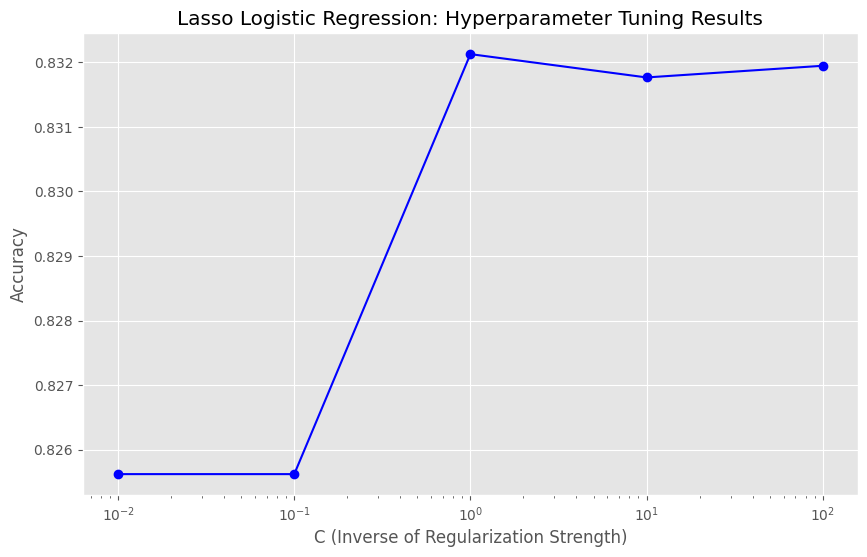

In [50]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(param_values, mean_test_scores, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Since C values are typically on a logarithmic scale
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Lasso Logistic Regression: Hyperparameter Tuning Results')
plt.grid(True)
plt.show()

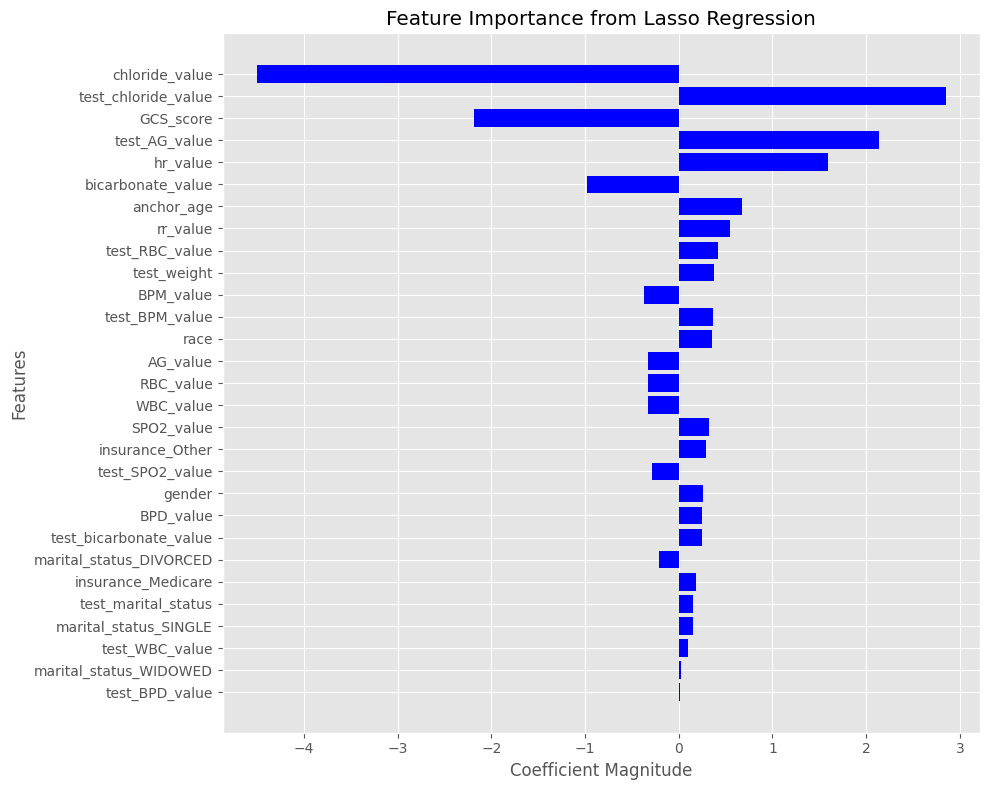

In [51]:
# Get coefficients and feature names
coefficients = lasso_best_model.coef_.ravel()
feature_names = np.array(X.columns)

# Filter out non-zero coefficients and corresponding feature names
important_features = feature_names[coefficients != 0]
important_coefficients = coefficients[coefficients != 0]

# Create a horizontal bar plot for feature importances
plt.figure(figsize=(10, 8))  # Adjust figure size as necessary
sorted_idx = np.argsort(np.abs(important_coefficients))  # Sort features by importance

plt.barh(important_features[sorted_idx], important_coefficients[sorted_idx], color='b')
plt.ylabel('Features', fontsize=12)  # You can adjust this font size as needed
plt.xlabel('Coefficient Magnitude', fontsize=12)  # Adjust font size for x-label
plt.title('Feature Importance from Lasso Regression')
plt.yticks(fontsize=10)  # Smaller font size for y-axis labels
plt.tight_layout()  # Adjust layout to make room for feature labels
plt.show()